<h1> Classification Model to Predict Loan Approval </h1>

<h2> Import packages/classes and load the data </h2>

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

<h2> Functions </h2>

In [85]:
def cm(y_pred, y_test, model=str, tuned=False, smote=False):
    """
    Creates the confusion matrix for the model and outputs the evaluation metrics

    Inputs:
    1. y_pred   :      Model predictions from test set
    2. y_test   :      Test set
    3.title     :      Name of the model -- Logistic Regression, SVM, Decision Tree
    4.tuned     :      Set to yes if the model was tuned. Default False
    5.smote     :      Set to yes if smote was applied to the data. Default False 
    """
    cm = confusion_matrix(y_test, y_pred)

    # Annotations for squares
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = [f'{value}' for value in cm.flatten()]
    labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
    labels = np.array(labels).reshape(2, 2)

    # Plot
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
   #plt.title(f"Confusion Martrix for {model}")
    if tuned==False and smote==False:
        plt.title(f"Confusion Martrix for {model}")
    elif tuned==True and smote==False:
        plt.title(f"Confusion Martrix for {model} (Tuned)")
    elif tuned==False and smote==True:
        plt.title(f"Confusion Martrix for {model} (Smote)")
    elif tuned==True and smote==True:
        plt.title(f"Confusion Martrix for {model} (Smote/Tuned)")
    plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
    plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
    plt.show()

    #Evaluate the model
    print("\n--- Model Evaluation ---")
    accuracyScore = accuracy_score(y_test, y_pred)
    precisionScore = precision_score(y_test, y_pred)
    recallScore = recall_score(y_test, y_pred)
    f1Score = f1_score(y_test, y_pred)

    print('Accuracy Score: ', accuracy_score(y_test, y_pred))
    print('Precision Score: ', precision_score(y_test, y_pred))
    print('Recall Score: ', recall_score(y_test, y_pred))
    print('F1 Score: ', f1_score(y_test, y_pred))

    tn = cm[0,0]
    fp = cm[0,1]
    specificity = tn/(tn+fp)
    print('Specificity: ', specificity)
    scores = [accuracyScore, precisionScore, recallScore, f1Score, specificity]

    return classification_report(y_test, y_pred)

def decisionTree(model, X_train, tuned=False, smote=False):
    """
    Creates the decision tree visual
    1. model    :   Decision Tree model
    2. X_train  :   X train set
    3.tuned     :   Set to yes if the model was tuned. Default False
    4.smote     :   Set to yes if smote was applied to the data. Default False
    """
    plt.figure(figsize=(25, 12))  
    plot_tree(model,
            filled=True,
            rounded=True,
            feature_names=X_train.columns,
            class_names=['Rejected', 'Approved'],
            fontsize=12,
            impurity=False,       
            proportion=True)
    if tuned==False and smote==False:
        plt.title("Decision Tree - Loan Approval Prediction", fontsize=12)
    elif tuned==True and smote==False:
        plt.title("Decision Tree (Tuned) - Loan Approval Prediction", fontsize=12)
    elif tuned==False and smote==True:
        plt.title("Decision Tree (Smote) - Loan Approval Prediction", fontsize=12)
    elif tuned==True and smote==True:
        plt.title("Decision Tre (Smote/Tuned) - Loan Approval Prediction", fontsize=12)
    #plt.title("Decision Tree - Loan Approval Prediction", fontsize=12)
    plt.tight_layout()
    plt.show()

    return None

def plot_learning_curve(estimator, title, X, y, axes=None, train_sizes=np.linspace(0.1, 1.0, 5), cv=None, scoring='accuracy'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.legend(loc="best")
    return plt

#  --- Hyperparameter Tuning Param Grids ---
# Logistic regression
lr_param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Decision tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}

# SVM Model
svm_param_grid = {
    'kernel': ['rbf'],
    'C': [1, 10]
}

In [14]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,person_education,Combined Master and Doctorate categories into one group -- Graduate,Doctorate had the lowest frequency out of all the categories which could impact analysis
6,person_home_ownership,Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category,RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis
7,"['person_gender', 'loan_intent', 'previous_loan_defaults_on_file', 'person_education_new', 'person_home_ownership_new']",Applied one-hot encoding (drop_first=True),Converted categorical variables into binary indicators for model compatibility.
8,loan_status,Readded loan_status column,Target variable for classification; readded after cleaning and preprocessing.


In [86]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

,person_age,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,log_income,log_loan_amt,person_gender_male,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,person_education_new_Bachelor,person_education_new_Graduate,person_education_new_High School,person_home_ownership_new_Non-Homeowner,loan_status
0,22,0,16.02,0.49,3,561,11.183713,10.463132,0,0,0,0,1,0,0,0,1,0,1,1
1,21,0,11.14,0.08,2,504,9.415971,6.908755,0,1,0,0,0,0,1,0,0,1,0,0
2,25,3,12.87,0.44,3,635,9.428592,8.612685,0,0,0,1,0,0,0,0,0,1,0,1
3,23,0,15.23,0.44,2,675,11.286702,10.463132,0,0,0,1,0,0,0,1,0,0,1,1
4,24,1,14.27,0.53,4,586,11.099469,10.463132,1,0,0,1,0,0,0,0,1,0,1,1


<h2> Data Prep </h2>

In [87]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [88]:
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (31494, 19)
X_test: (13498, 19)


In [18]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Check for class imbalance
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set:\n{y_test.value_counts(normalize=True)}")

# Changelog addition
changelog.append({
    'column': 'numerical_columns',
    'change': 'Applied MinMaxScaler to training data; transformed test data using same scaler.',
    'rationale': 'Avoided data leakage by fitting scaler only on training data. Ensures proper model generalization and adheres to machine learning best practices.'
})

Class distribution in training set:
loan_status
0    0.777799
1    0.222201
Name: proportion, dtype: float64
Class distribution in test set:
loan_status
0    0.777819
1    0.222181
Name: proportion, dtype: float64


<h3> Apply Smote to handle the imbalance data </h3>

In [19]:
# SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after SMOTE
X_smote_test = X_test_scaled
y_smote_test = y_test

# Changelog entry for SMOTE
changelog.append({
    'column': 'subscribe_to_term_deposit',
    'change': f'Resampled training set with SMOTE (train shape now: {X_smote_train.shape}, test shape: {X_test.shape})',
    'rationale': 'Used SMOTE to correct class imbalance in training data for better model performance.'
})

<h2> Build the Models </h2>

<h3> Model 1: Logistic Regression </h3>

In [ ]:
# Logistic Regression -- Base Model
lrBase = LogisticRegression(max_iter=1000)
lrBase.fit(X_train_scaled, y_train)

# Logistic Regression - Smote Model
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_smote_train, y_smote_train)

<h3> Model 2: Decision Tree </h3>

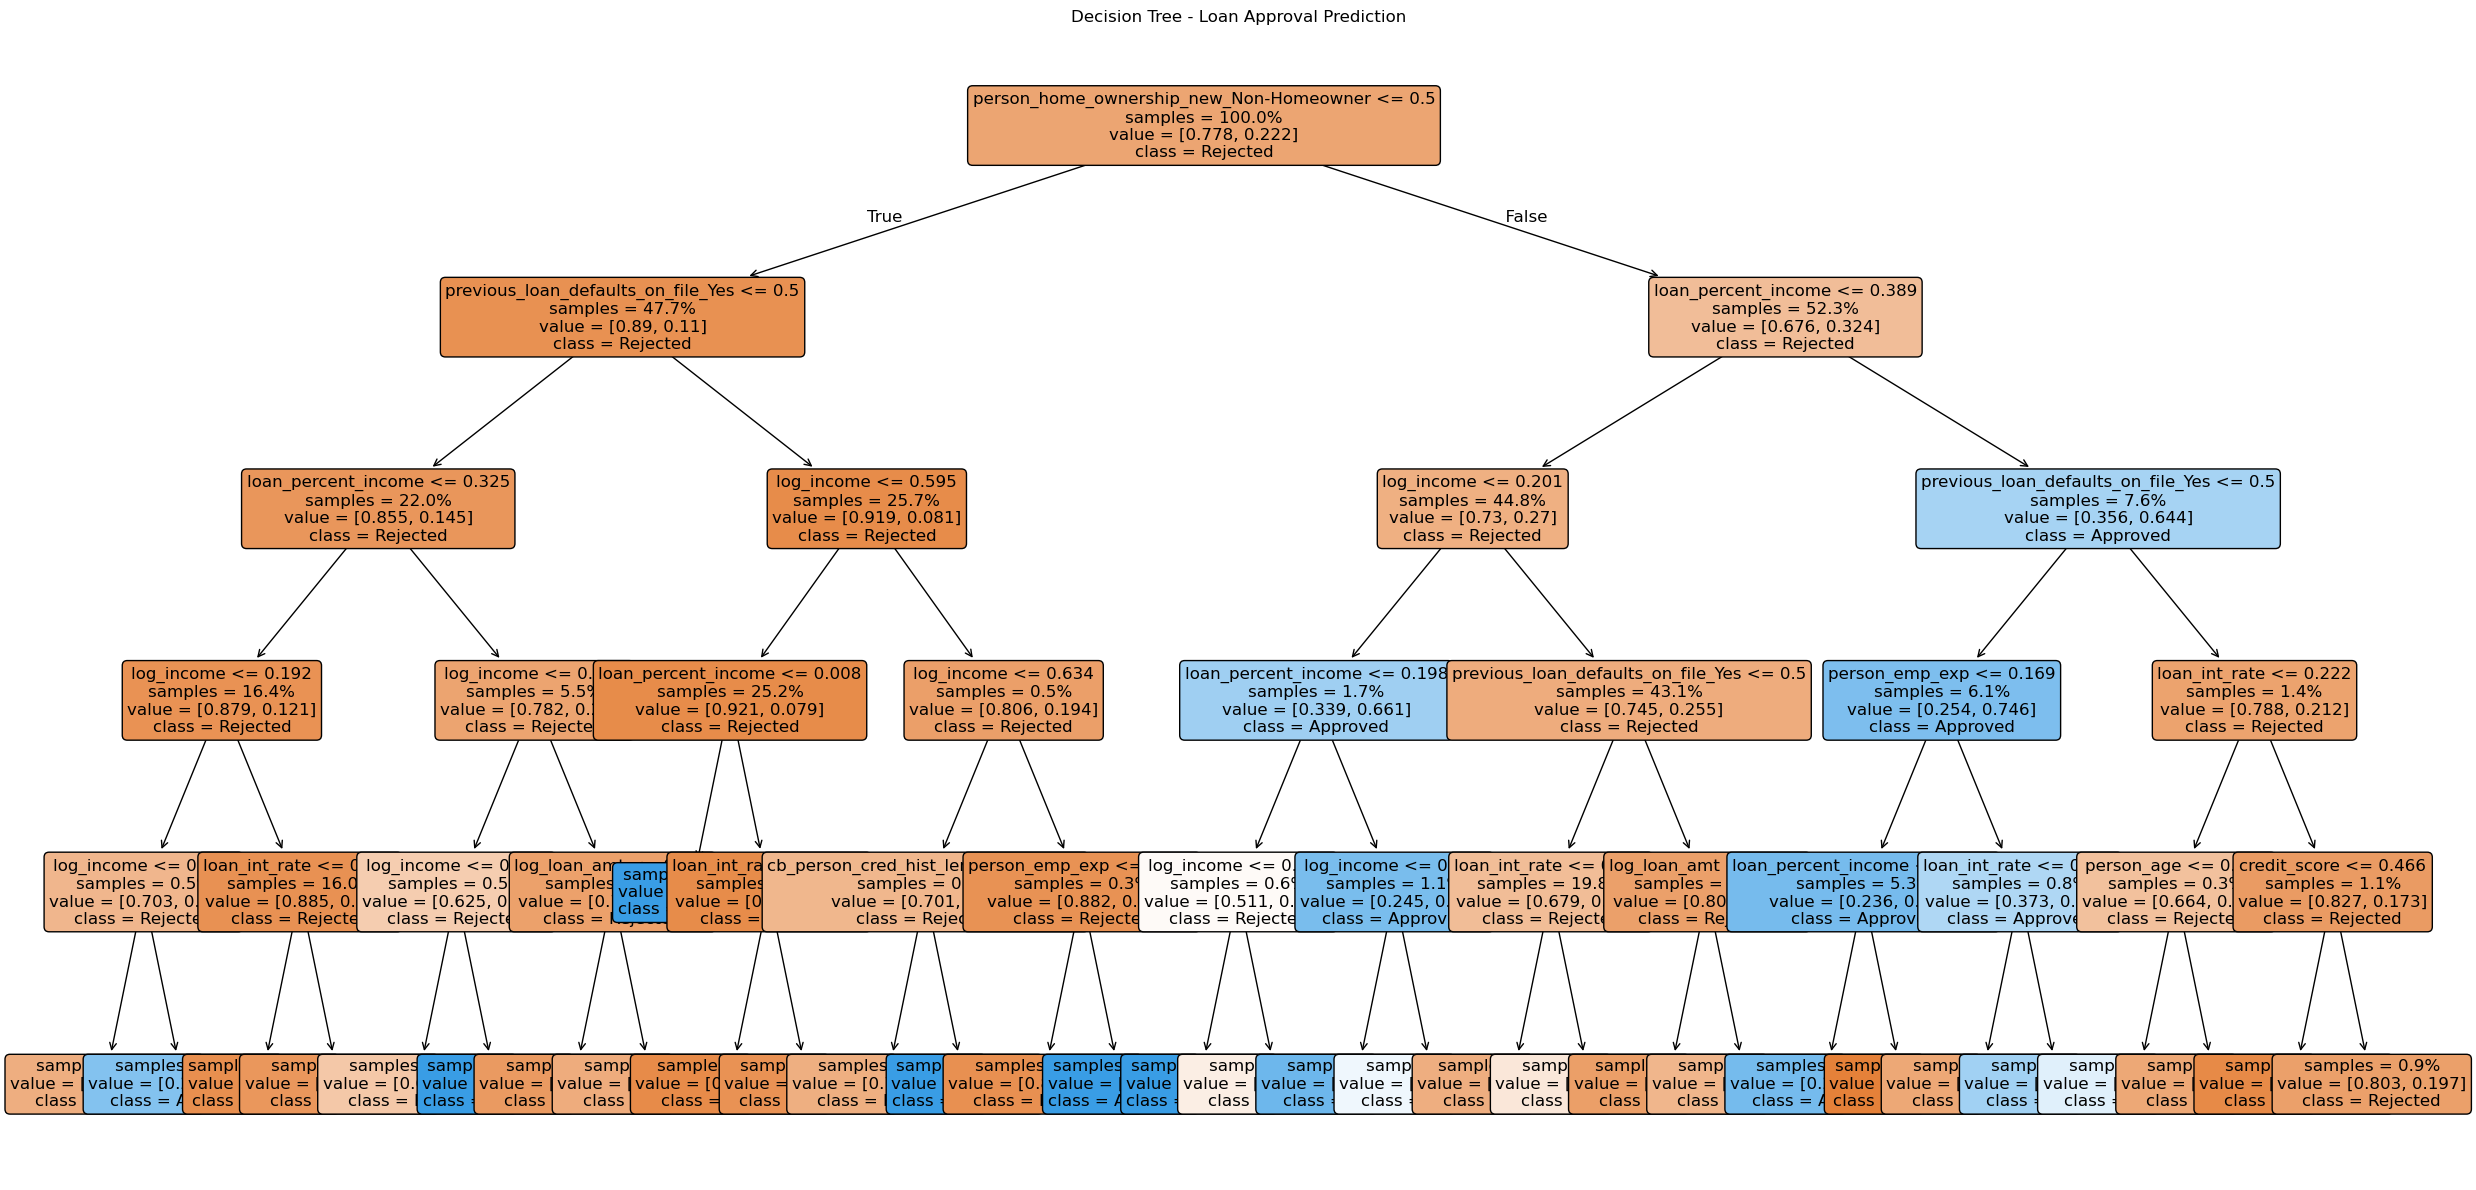

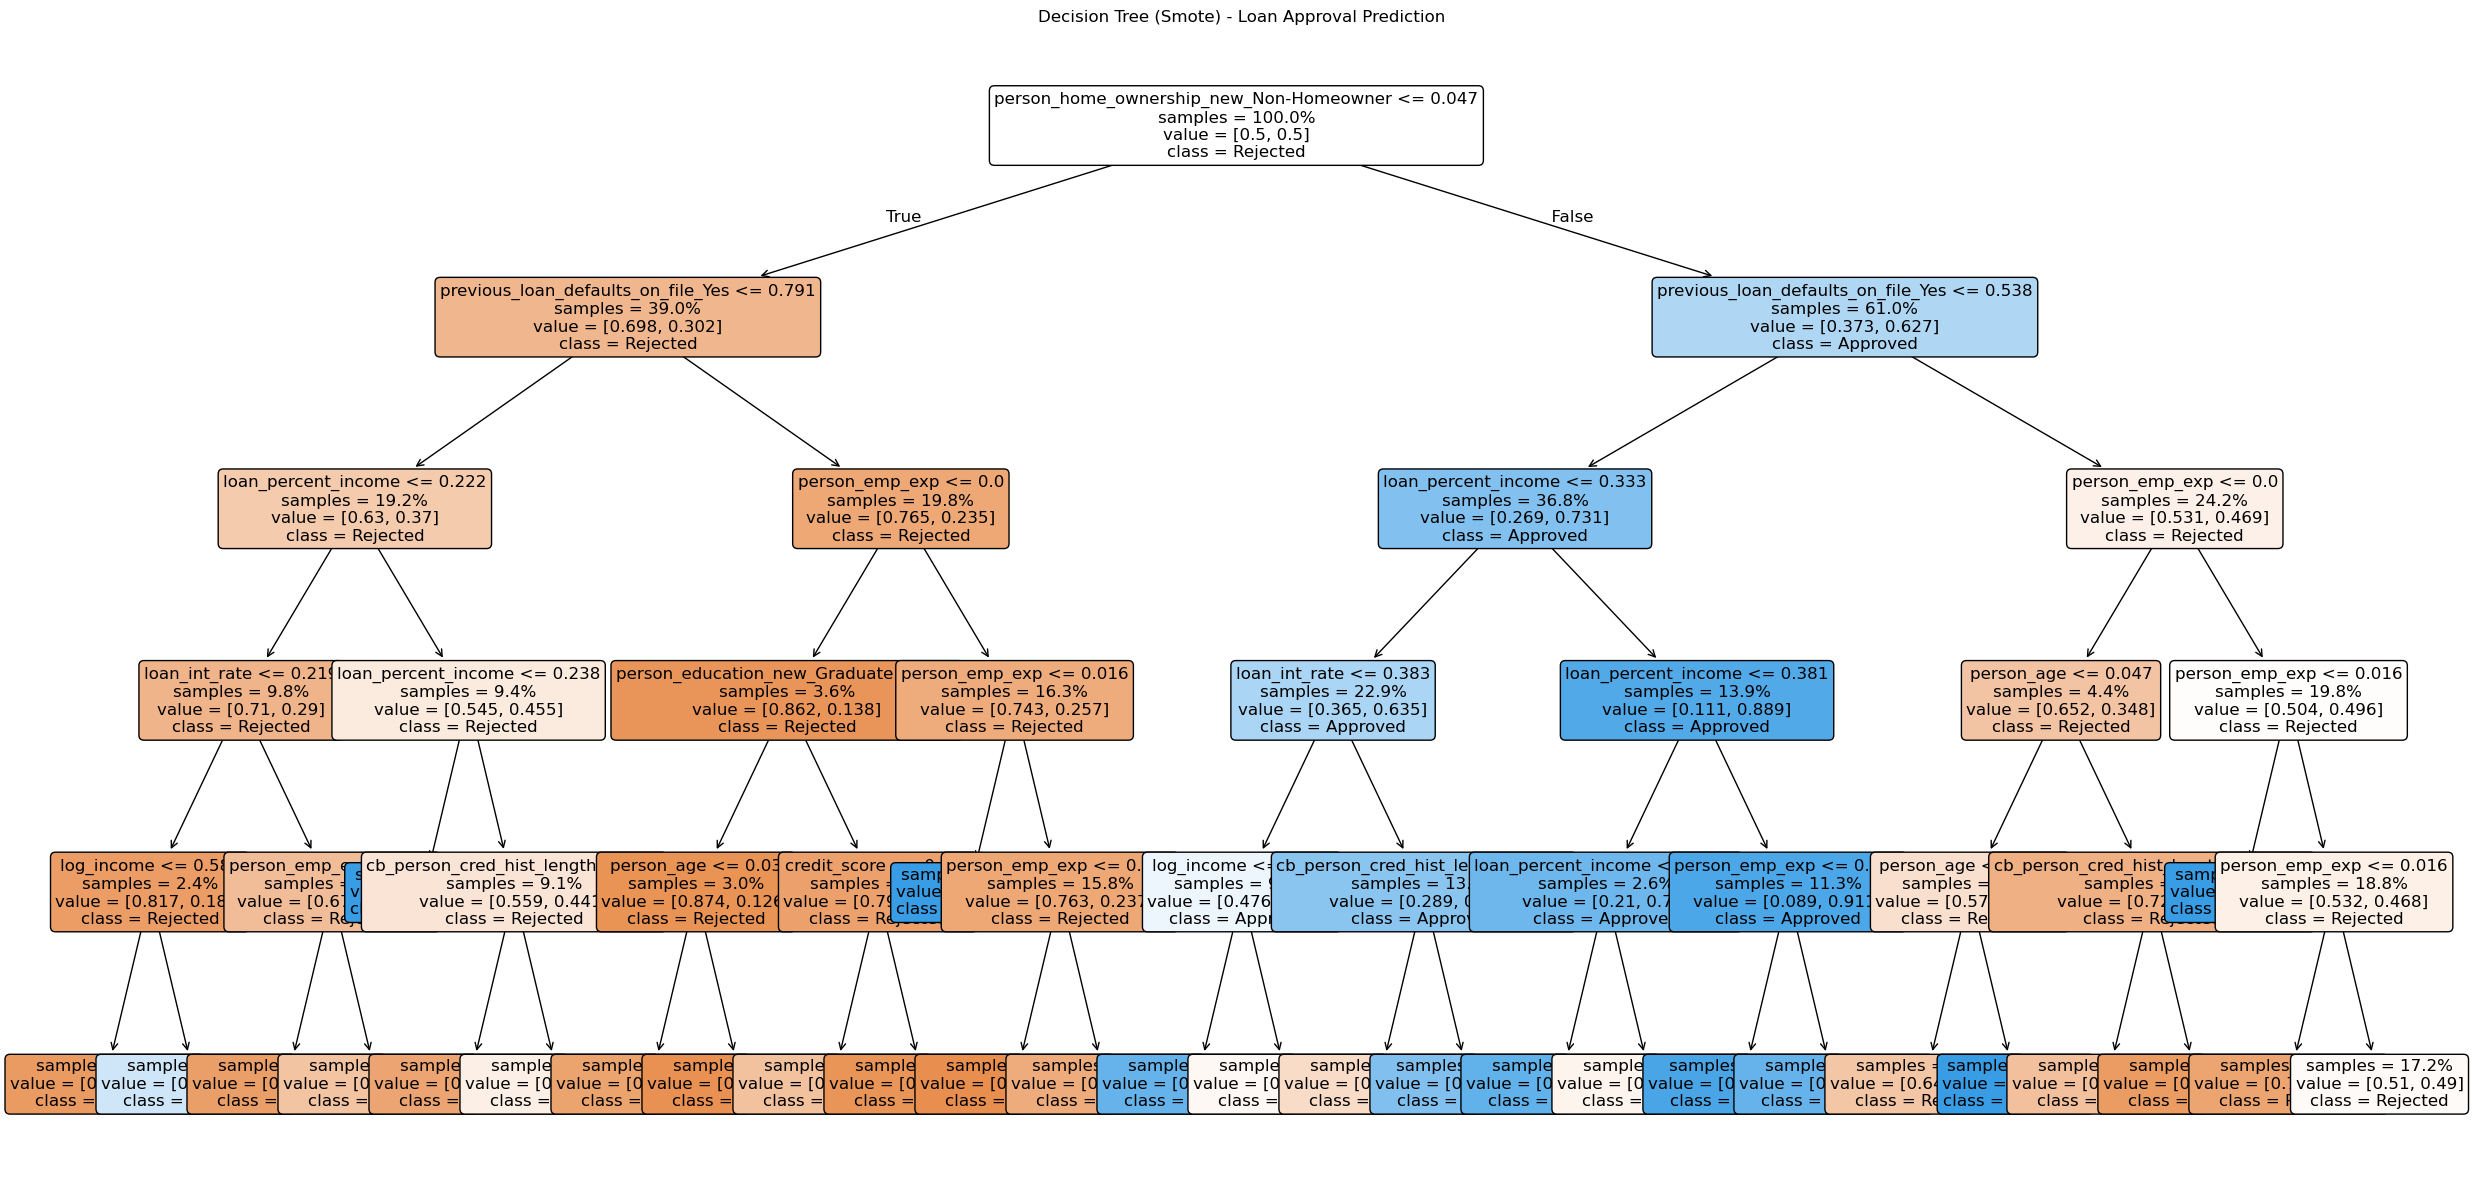

In [67]:
# Decision Tree -- Base Model
dt_model = DecisionTreeClassifier(max_depth=5,random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Visualize the Decision Tree
decisionTree(dt_model, X_train)

# Decision Tree -- Smote Model
smote_dt_model = DecisionTreeClassifier(max_depth=5,random_state=42)
smote_dt_model.fit(X_smote_train, y_smote_train)

# Visualize the Decision Tree
decisionTree(smote_dt_model, X_train, smote=True)


<h3> Model 3: SVM </h3>

In [ ]:
# SVM -- Base Model
svmBase = SVC(kernel='rbf', C=10, random_state=42)
svmBase.fit(X_train_scaled, y_train)

# SVM -- Smote Model
svm_smote = SVC(kernel='rbf', C=10, random_state=42)
svm_smote.fit(X_smote_train, y_smote_train)

<h2> Model Evaluation </h2>

<h4> Logistic Regression </h4>

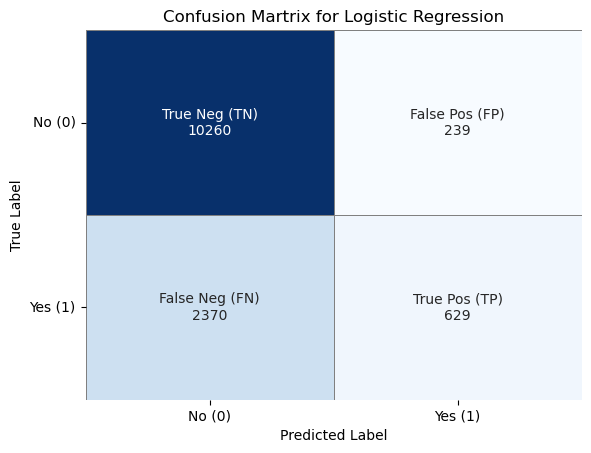


--- Model Evaluation ---
Accuracy Score:  0.8067121054971107
Precision Score:  0.7246543778801844
Recall Score:  0.20973657885961988
F1 Score:  0.3253167830359452
Specificity:  0.9772359272311649
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     10499
           1       0.72      0.21      0.33      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.59      0.61     13498
weighted avg       0.79      0.81      0.76     13498



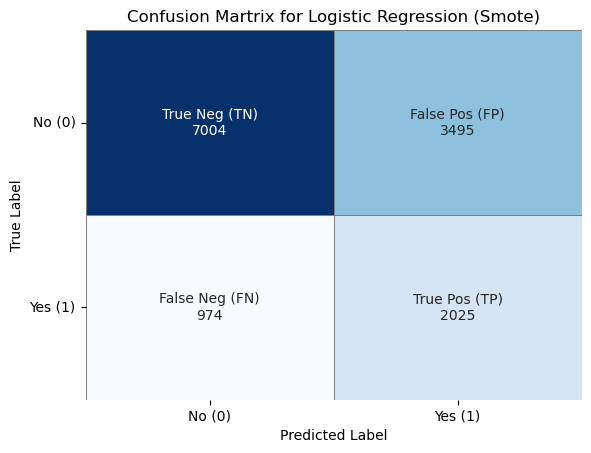


--- Model Evaluation ---
Accuracy Score:  0.6689139131723219
Precision Score:  0.36684782608695654
Recall Score:  0.6752250750250083
F1 Score:  0.47540791172672847
Specificity:  0.6671111534431851
              precision    recall  f1-score   support

           0       0.88      0.67      0.76     10499
           1       0.37      0.68      0.48      2999

    accuracy                           0.67     13498
   macro avg       0.62      0.67      0.62     13498
weighted avg       0.76      0.67      0.70     13498



In [56]:
# Base Model 
lr_pred = lrBase.predict(X_test_scaled)
print(cm(lr_pred, y_test, 'Logistic Regression'))

# Smote Model
lr_smote_pred = lr_smote.predict(X_test_scaled)
print(cm(lr_smote_pred, y_smote_test, 'Logistic Regression', smote=True))


<h3> Decision Tree </h3>

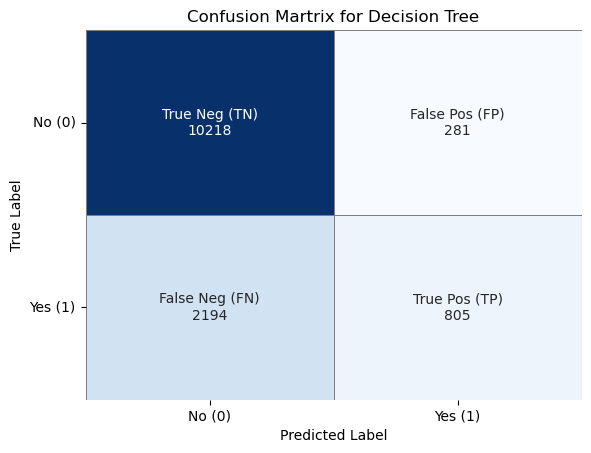


--- Model Evaluation ---
Accuracy Score:  0.8166395021484665
Precision Score:  0.7412523020257827
Recall Score:  0.2684228076025342
F1 Score:  0.39412484700122397
Specificity:  0.9732355462424993
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     10499
           1       0.74      0.27      0.39      2999

    accuracy                           0.82     13498
   macro avg       0.78      0.62      0.64     13498
weighted avg       0.81      0.82      0.78     13498



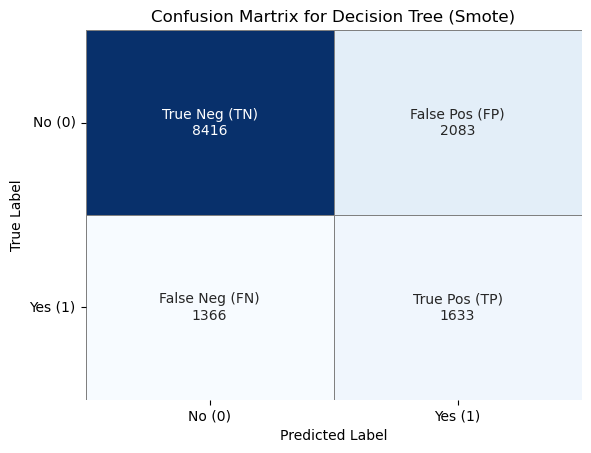


--- Model Evaluation ---
Accuracy Score:  0.7444806638020447
Precision Score:  0.43945102260495156
Recall Score:  0.5445148382794265
F1 Score:  0.48637379002233805
Specificity:  0.8016001523954662
              precision    recall  f1-score   support

           0       0.86      0.80      0.83     10499
           1       0.44      0.54      0.49      2999

    accuracy                           0.74     13498
   macro avg       0.65      0.67      0.66     13498
weighted avg       0.77      0.74      0.75     13498



In [58]:
#Base Model
dt_predictions = dt_model.predict(X_test_scaled)
print(cm(dt_predictions, y_test, 'Decision Tree'))

#Smote Model
smote_dt_predictions = smote_dt_model.predict(X_smote_test)
print(cm(smote_dt_predictions, y_smote_test, 'Decision Tree', smote=True))

<h3> SVM </h3>

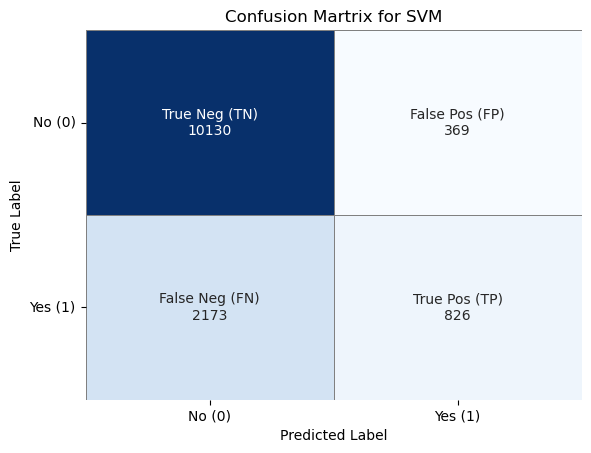


--- Model Evaluation ---
Accuracy Score:  0.8116758038227886
Precision Score:  0.6912133891213389
Recall Score:  0.27542514171390464
F1 Score:  0.3938960419647115
Specificity:  0.964853795599581
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     10499
           1       0.69      0.28      0.39      2999

    accuracy                           0.81     13498
   macro avg       0.76      0.62      0.64     13498
weighted avg       0.79      0.81      0.78     13498



In [60]:
# Base Model
svm_pred = svmBase.predict(X_test_scaled)
print(cm(svm_pred, y_test, 'SVM'))

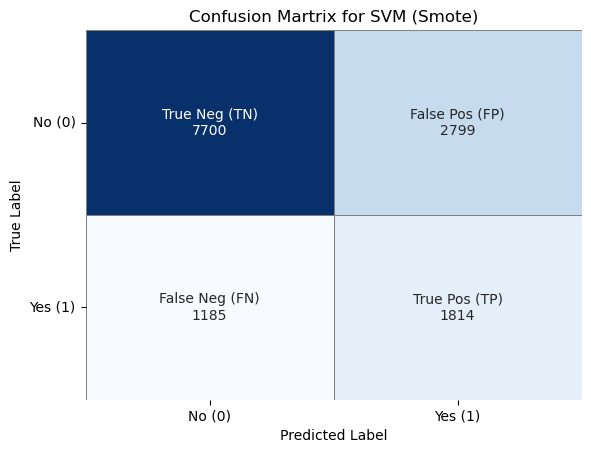


--- Model Evaluation ---
Accuracy Score:  0.7048451622462587
Precision Score:  0.39323650552785605
Recall Score:  0.60486828942981
F1 Score:  0.4766158696794535
Specificity:  0.7334031812553576
              precision    recall  f1-score   support

           0       0.87      0.73      0.79     10499
           1       0.39      0.60      0.48      2999

    accuracy                           0.70     13498
   macro avg       0.63      0.67      0.64     13498
weighted avg       0.76      0.70      0.72     13498



In [61]:
# Smote Model
svm_pred_smote = svm_smote.predict(X_smote_test)
print(cm(svm_pred_smote, y_smote_test, 'SVM', smote=True))

<h2> Hyper Parameter Tuning </h2>

<h3> Logistic Regression </h3>


Logistic Regression Best Parameters: {'C': 2.782559402207126, 'penalty': 'l1', 'solver': 'liblinear'}


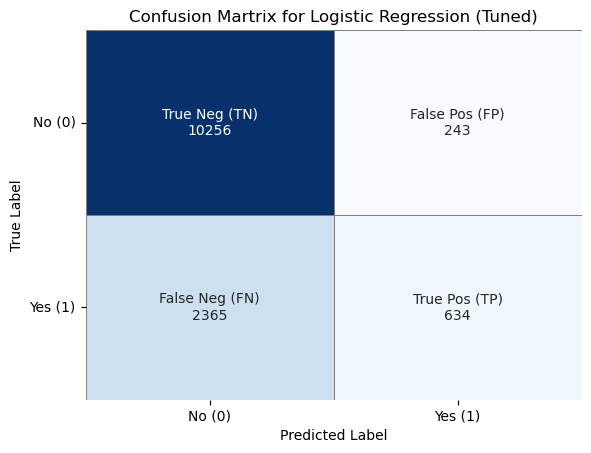


--- Model Evaluation ---
Accuracy Score:  0.8067861905467477
Precision Score:  0.7229190421892816
Recall Score:  0.21140380126708902
F1 Score:  0.32714138286893707
Specificity:  0.9768549385655777
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     10499
           1       0.72      0.21      0.33      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.59      0.61     13498
weighted avg       0.79      0.81      0.76     13498


Logistic Regression (Smote) Best Parameters: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}


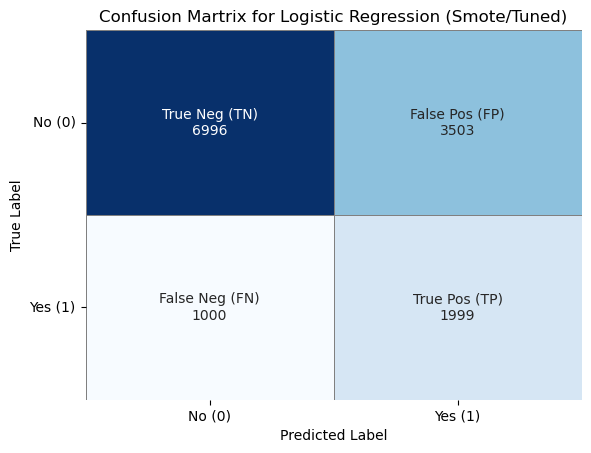


--- Model Evaluation ---
Accuracy Score:  0.6663950214846643
Precision Score:  0.3633224282079244
Recall Score:  0.6665555185061687
F1 Score:  0.4702976120456417
Specificity:  0.6663491761120107
              precision    recall  f1-score   support

           0       0.87      0.67      0.76     10499
           1       0.36      0.67      0.47      2999

    accuracy                           0.67     13498
   macro avg       0.62      0.67      0.61     13498
weighted avg       0.76      0.67      0.69     13498



In [70]:
# ---- Logistic Regression - Tuning ----
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid, cv=5, scoring='f1', n_jobs=-1)
lr_grid_search.fit(X_train_scaled, y_train)

print("\nLogistic Regression Best Parameters:", lr_grid_search.best_params_)
lr_best_model = lr_grid_search.best_estimator_

#Generate the predictions
lr_tuned_predictions = lr_best_model.predict(X_test_scaled)

#Evaluate the model
print(cm(lr_tuned_predictions, y_test, 'Logistic Regression', tuned=True))

# ---- Logistic Regression - Tuning with SMOTE ----
lr_grid_search_smote = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid, cv=5, scoring='f1', n_jobs=-1)
lr_grid_search_smote.fit(X_smote_train, y_smote_train)

print("\nLogistic Regression (Smote) Best Parameters:", lr_grid_search_smote.best_params_)
lr_best_model_smote = lr_grid_search_smote.best_estimator_

#Generate the predictions
lr_tuned_predictions_smote = lr_best_model_smote.predict(X_smote_test)

#Evaluate the model
print(cm(lr_tuned_predictions_smote, y_test, 'Logistic Regression', tuned=True, smote=True))

<h3> Decision Tree </h3>


Decision Tree Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}


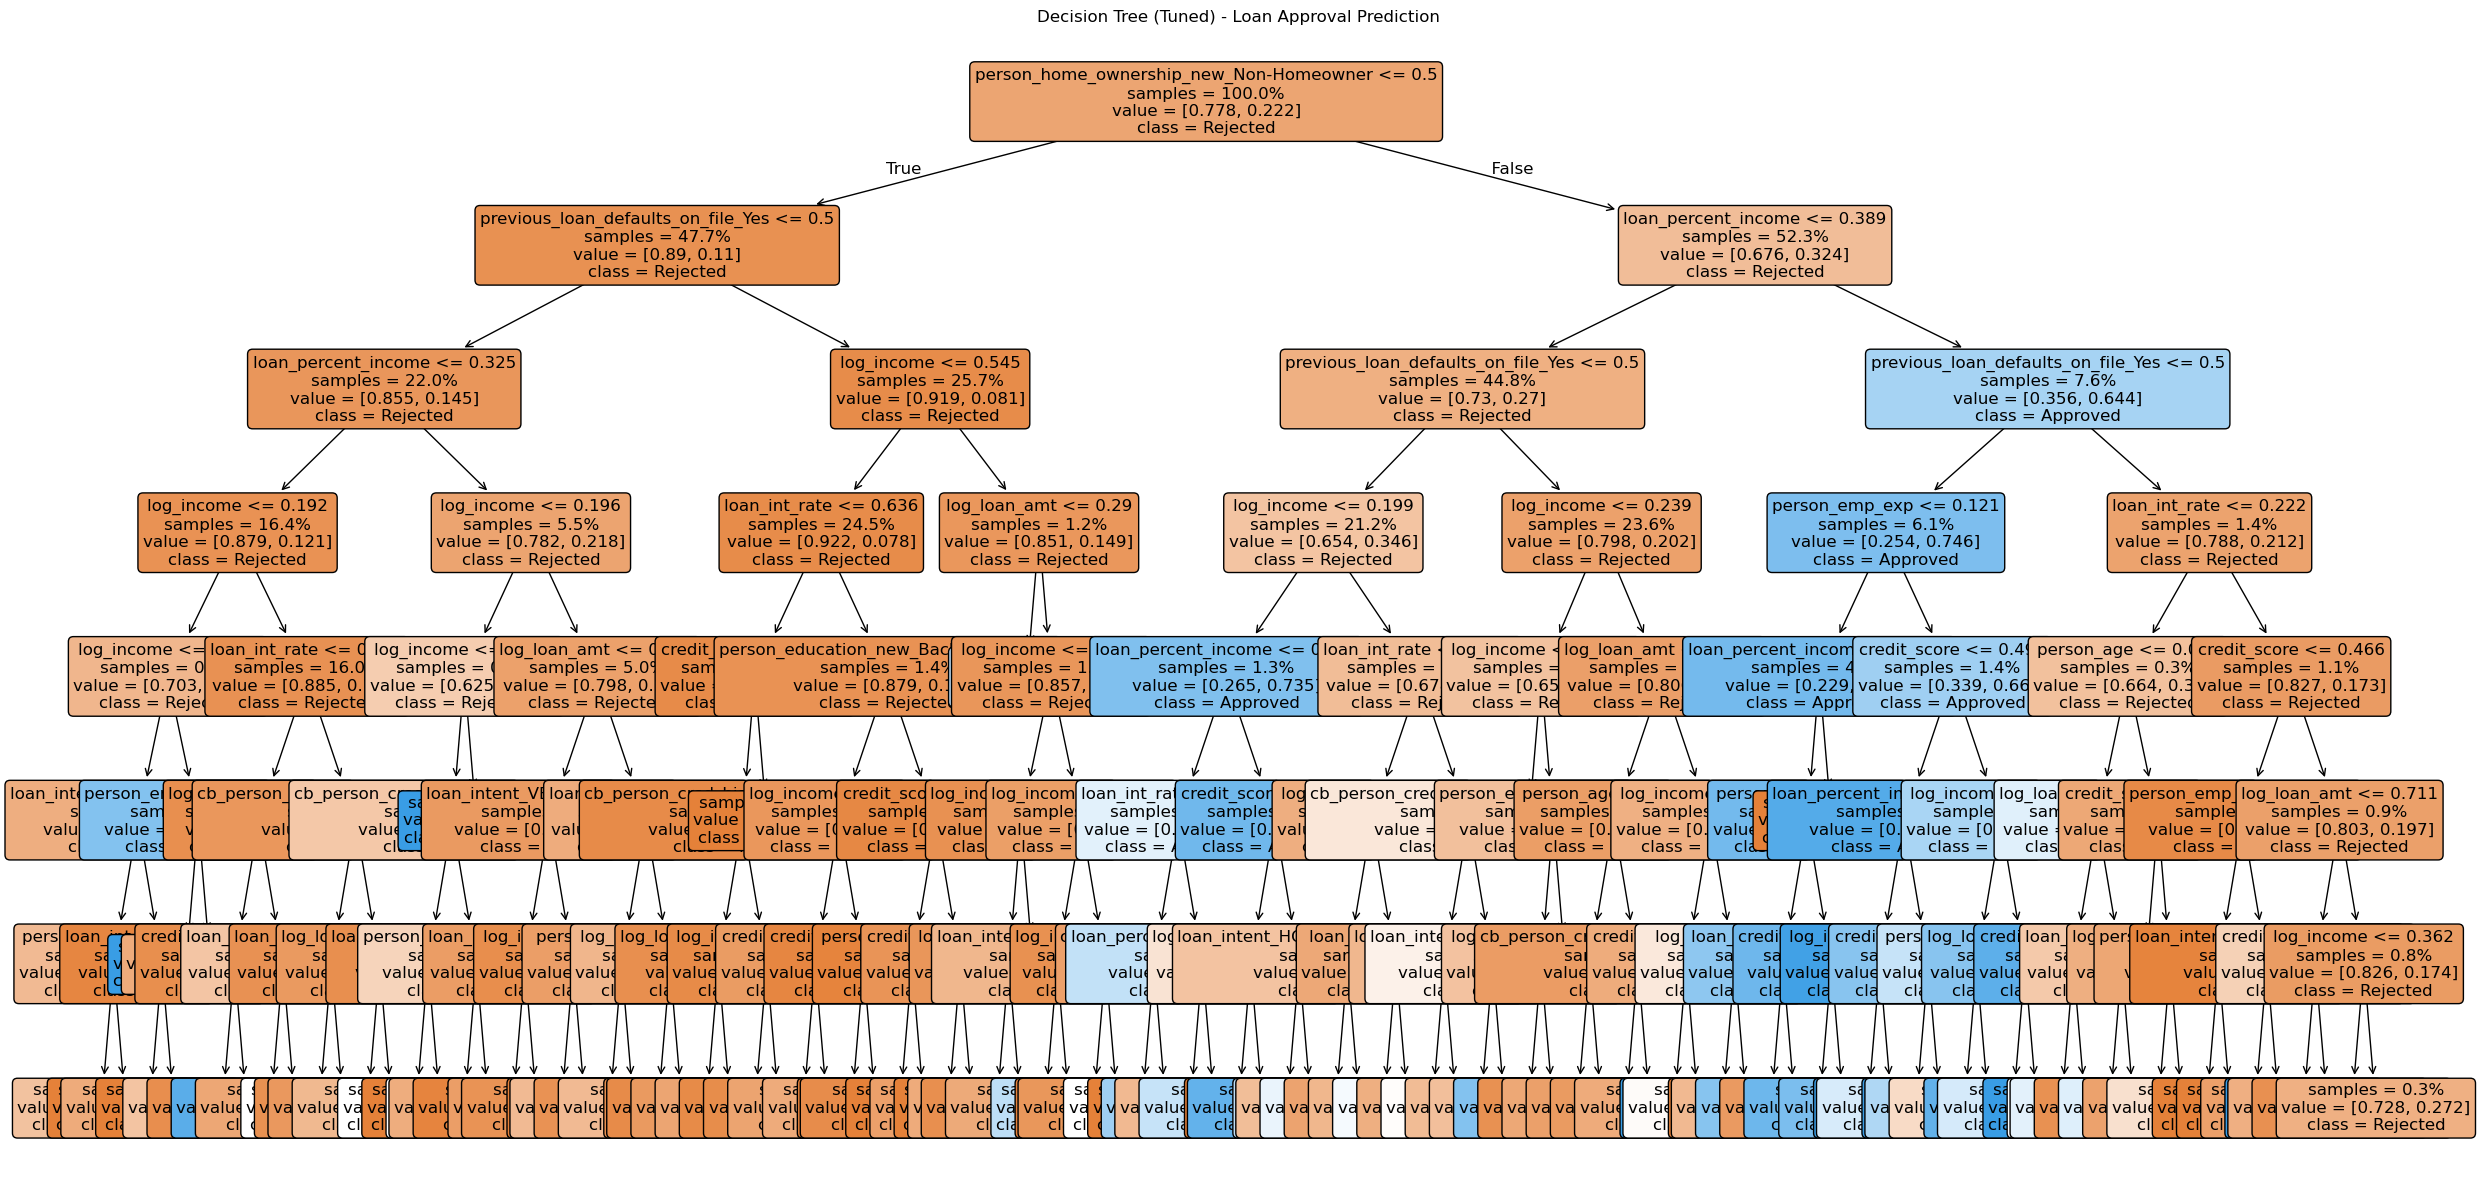

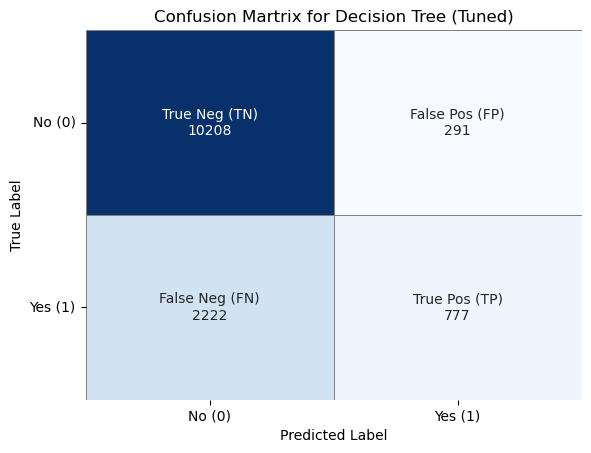


--- Model Evaluation ---
Accuracy Score:  0.8138242702622611
Precision Score:  0.7275280898876404
Recall Score:  0.2590863621207069
F1 Score:  0.38209982788296043
Specificity:  0.9722830745785312
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     10499
           1       0.73      0.26      0.38      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.62      0.64     13498
weighted avg       0.80      0.81      0.78     13498


Decision Tree(Smote) Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}


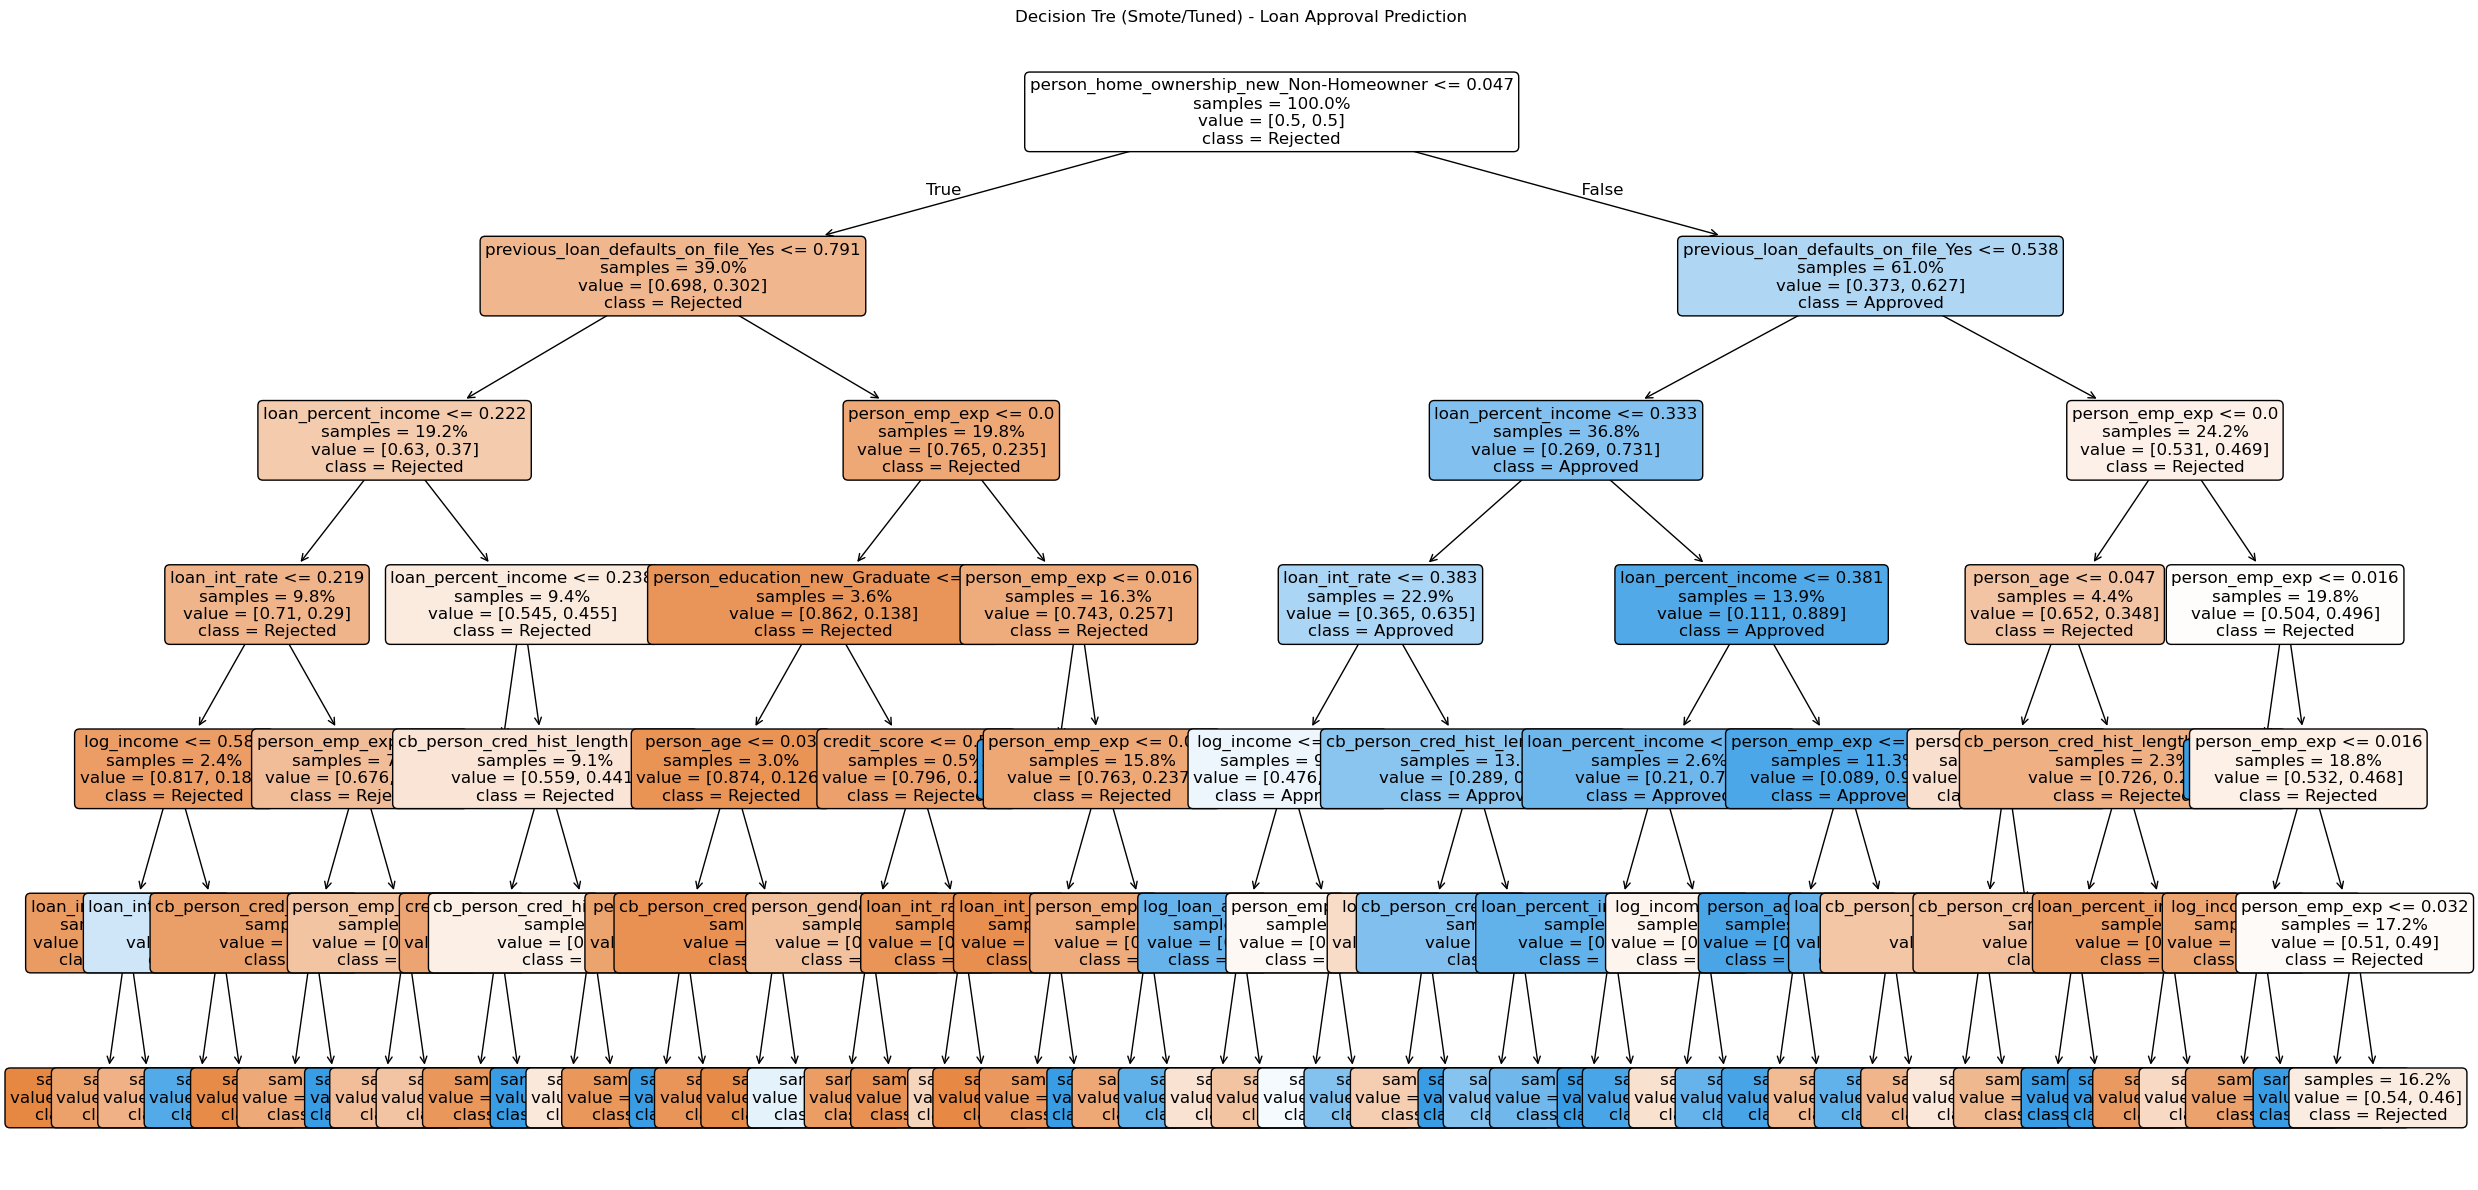

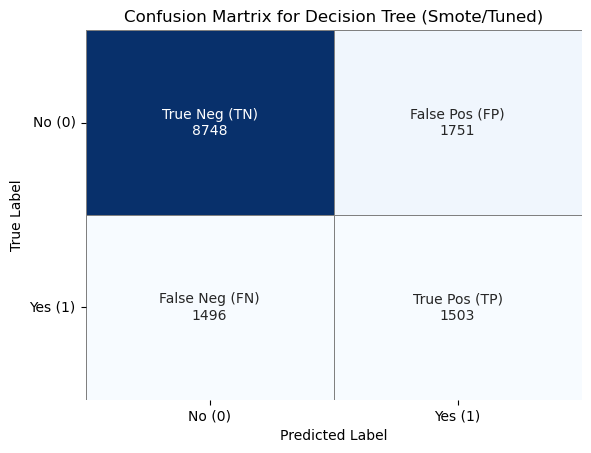


--- Model Evaluation ---
Accuracy Score:  0.7594458438287154
Precision Score:  0.46189305470190534
Recall Score:  0.5011670556852285
F1 Score:  0.4807292499600192
Specificity:  0.8332222116392037
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     10499
           1       0.46      0.50      0.48      2999

    accuracy                           0.76     13498
   macro avg       0.66      0.67      0.66     13498
weighted avg       0.77      0.76      0.76     13498



In [82]:
# ---- Decision Tree - Tuning ----
dt_grid_search = GridSearchCV(DecisionTreeClassifier(max_depth=5,random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid_search.fit(X_train_scaled, y_train)
print("\nDecision Tree Best Parameters:", dt_grid_search.best_params_)

dt_best_model = dt_grid_search.best_estimator_

# Visualize the Decision Tree
decisionTree(dt_best_model, X_train, tuned=True)

# Generate the predictions 
dt_pred_tuned = dt_best_model.predict(X_test_scaled)

#Evaluate the model
print(cm(dt_pred_tuned, y_test, 'Decision Tree', tuned=True))

# --- Decision Tree - Tuning with SMOTE ---
dt_grid_search_smote = GridSearchCV(DecisionTreeClassifier(max_depth=5,random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid_search_smote.fit(X_smote_train, y_smote_train)
print("\nDecision Tree(Smote) Best Parameters:", dt_grid_search_smote.best_params_)

dt_best_model_smote = dt_grid_search_smote.best_estimator_

# Visualize the Decision Tree
decisionTree(dt_best_model_smote, X_train, tuned=True, smote=True)

# Generate the predictions
dt_pred_smote = dt_best_model_smote.predict(X_smote_test)

# Evaluate the model
print(cm(dt_pred_smote, y_smote_test, 'Decision Tree', tuned=True, smote=True))

<h3> SVM </h3>


 SVM Best Parameters: {'C': 10, 'kernel': 'rbf'}


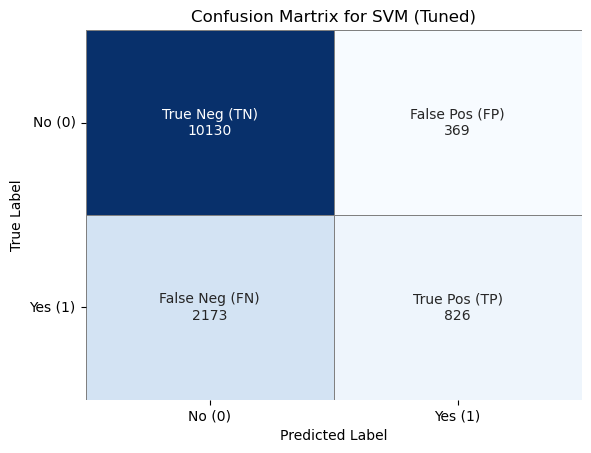


--- Model Evaluation ---
Accuracy Score:  0.8116758038227886
Precision Score:  0.6912133891213389
Recall Score:  0.27542514171390464
F1 Score:  0.3938960419647115
Specificity:  0.964853795599581
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     10499
           1       0.69      0.28      0.39      2999

    accuracy                           0.81     13498
   macro avg       0.76      0.62      0.64     13498
weighted avg       0.79      0.81      0.78     13498


 SVM (Smote) Best Parameters: {'C': 10, 'kernel': 'rbf'}


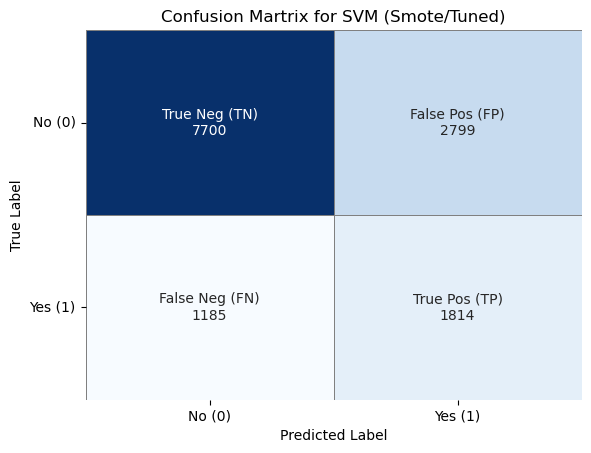


--- Model Evaluation ---
Accuracy Score:  0.7048451622462587
Precision Score:  0.39323650552785605
Recall Score:  0.60486828942981
F1 Score:  0.4766158696794535
Specificity:  0.7334031812553576
              precision    recall  f1-score   support

           0       0.87      0.73      0.79     10499
           1       0.39      0.60      0.48      2999

    accuracy                           0.70     13498
   macro avg       0.63      0.67      0.64     13498
weighted avg       0.76      0.70      0.72     13498



In [76]:
# ---- SVM - Tuning ----
svm_grid_search =  GridSearchCV(SVC(random_state=42),
                               param_grid=svm_param_grid, cv=5, scoring='f1', n_jobs=-1)
svm_grid_search.fit(X_train_scaled, y_train)

# Print out the best parameters
print("\n SVM Best Parameters:", svm_grid_search.best_params_)
svm_best_model = svm_grid_search.best_estimator_

# Generate the predictions
svm_tuned_pred = svm_best_model.predict(X_test_scaled)

# Evaluate the model
print(cm(svm_tuned_pred, y_test, 'SVM', tuned=True))

# ---- SVM - Tuning with smote ----
# Create GridSearchCV
svm_grid_search_smote =  GridSearchCV(SVC(random_state=42),
                               param_grid=svm_param_grid, cv=5, scoring='f1', n_jobs=-1)
svm_grid_search_smote.fit(X_smote_train, y_smote_train)

#Print out the best parameters
print("\n SVM (Smote) Best Parameters:", svm_grid_search_smote.best_params_)

svm_best_model_smote = svm_grid_search_smote.best_estimator_

# Generate the predictions
svm_tuned_smote_pred = svm_best_model_smote.predict(X_smote_test)

#Evaluate the model
print(cm(svm_tuned_smote_pred, y_smote_test, 'SVM', tuned=True, smote=True))

Based on our hyperparemeter tuning, we can see that our original base and smote models were using the best parameters, so we will continue to use those models for SVM.

<h2> Cross-Validation </h2>

<h3> Logistic Regression </h3>

In [74]:
# Cross-validation for Logistic Regression
lr_cv_scores = cross_val_score(lrBase,
                               X_train_scaled, y_train, cv=5, scoring='f1')

# Cross-validation for Logistic Regression with smote
lr_cv_scores_smote = cross_val_score(lr_smote,
                                     X_smote_train, y_smote_train, cv=5, scoring='f1')

#Cross-validation for tuned Logistic Regression
lr_cv_best_model_scores = cross_val_score(lr_best_model,
                                          X_train_scaled, y_train, cv=5, scoring='f1')

#Cross-validation for tuned Logistic Regression with smote
lr_cv_best_model_scores_smote = cross_val_score(lr_best_model_smote,
                                                X_smote_train, y_smote_train, cv=5, scoring='f1')

print("Logistic Regression Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV F1 Score':<20}")
print(f"{'Original':<20}{lr_cv_scores.mean():<20.4f}")
print(f"{'SMOTE':<20}{lr_cv_scores_smote.mean():<20.4f}")
print(f"{'Tuned':<20}{lr_cv_best_model_scores.mean():<20.4f}")
print(f"{'Tuned + SMOTE':<20}{lr_cv_best_model_scores_smote.mean():<20.4f}")

Logistic Regression Cross-Validation Comparison:
Dataset             Mean CV F1 Score    
Original            0.3246              
SMOTE               0.6690              
Tuned               0.3259              
Tuned + SMOTE       0.6718              


<h4> Decision Tree </h4>

In [75]:
# Cross-validation for Decision Tree
dt_cv_scores = cross_val_score(dt_model,
                                X_train_scaled, y_train, cv=5, scoring='f1')

#Cross-validation for Decision Tree with smote
dt_cv_smote_scores = cross_val_score(smote_dt_model,
                                X_smote_train, y_smote_train, cv=5, scoring='f1')

#Cross-validation for tuned Decision Tree
dt_cv_best_model_scores = cross_val_score(dt_best_model,
                                X_train_scaled, y_train, cv=5, scoring='f1')

# Cross-validation for tuned Decision Tree with smote
dt_cv_smote_best_model_scores = cross_val_score(dt_best_model_smote,
                                X_smote_train, y_smote_train, cv=5, scoring='f1')

print("Decision Tree Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV F1 Score':<20}")
print(f"{'Original':<20}{dt_cv_scores.mean():<20.4f}")
print(f"{'SMOTE':<20}{dt_cv_smote_scores.mean():<20.4f}")
print(f"{'Tuned':<20}{dt_cv_best_model_scores.mean():<20.4f}")
print(f"{'Tuned + SMOTE':<20}{dt_cv_smote_best_model_scores.mean():<20.4f}")


Decision Tree Cross-Validation Comparison:
Dataset             Mean CV F1 Score    
Original            0.3669              
SMOTE               0.6376              
Tuned               0.4199              
Tuned + SMOTE       0.6727              


<h4> SVM </h4>

In [77]:
#Cross-validation for SVM
svm_cv_scores = cross_val_score(svmBase,
                                X_train_scaled, y_train, cv=5, scoring='f1')

#Cross-validation for SVM with smote
svm_cv_scores_smote = cross_val_score(svm_smote,
                                X_smote_train, y_smote_train, cv=5, scoring='f1')
"""
#Cross-validation for tuned SVM
svm_cv_best_model_scores = cross_val_score(svm_best_model,
                                X_train_scaled, y_train, cv=5, scoring='f1')

#Cross-validation for SVM with smote
svm_cv_best_model_smote_scores = cross_val_score(svm_best_model_smote,
                                X_smote_train, y_smote_train, cv=5, scoring='f1')
"""

print("SVM Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV F1 Score':<20}")
print(f"{'Origina/Tuned':<20}{svm_cv_scores.mean():<20.4f}")
print(f"{'SMOTE/Tuned':<20}{svm_cv_scores_smote.mean():<20.4f}")
#print(f"{'Tuned':<20}{svm_cv_best_model_scores.mean():<20.4f}")
#print(f"{'Tuned + SMOTE':<20}{svm_cv_best_model_smote_scores.mean():<20.4f}")

SVM Cross-Validation Comparison:
Dataset             Mean CV F1 Score    
Origina/Tuned       0.3858              
SMOTE/Tuned         0.6916              


Based on our cross-validation comparisons, we can see that the best models across all three algorithms are the models that have been balanced with smote and tuned. We will know compare the tuned and smote models to determine the overall best model.

<h2> Model Comparison </h2>

--- Logistic Regression ---


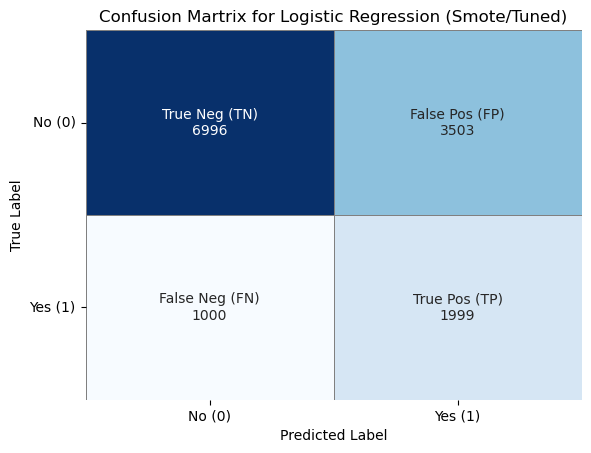


--- Model Evaluation ---
Accuracy Score:  0.6663950214846643
Precision Score:  0.3633224282079244
Recall Score:  0.6665555185061687
F1 Score:  0.4702976120456417
Specificity:  0.6663491761120107
--- Decision Tree ---


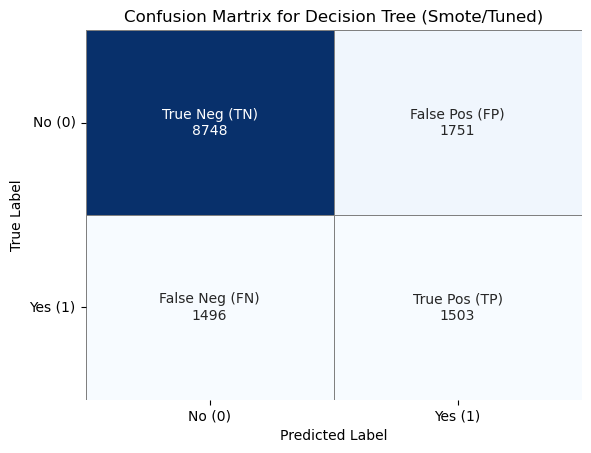


--- Model Evaluation ---
Accuracy Score:  0.7594458438287154
Precision Score:  0.46189305470190534
Recall Score:  0.5011670556852285
F1 Score:  0.4807292499600192
Specificity:  0.8332222116392037
--- SVM ---


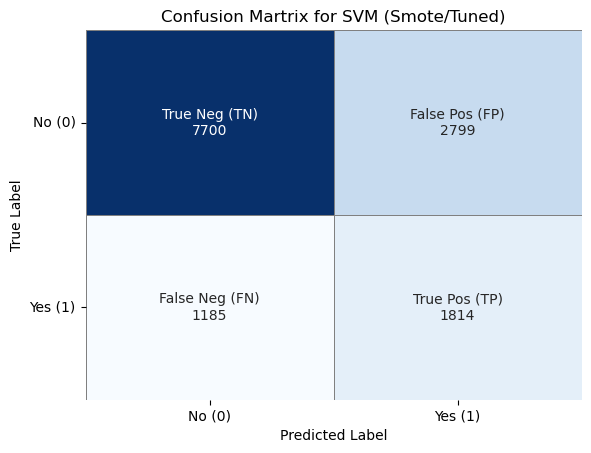


--- Model Evaluation ---
Accuracy Score:  0.7048451622462587
Precision Score:  0.39323650552785605
Recall Score:  0.60486828942981
F1 Score:  0.4766158696794535
Specificity:  0.7334031812553576


'              precision    recall  f1-score   support\n\n           0       0.87      0.73      0.79     10499\n           1       0.39      0.60      0.48      2999\n\n    accuracy                           0.70     13498\n   macro avg       0.63      0.67      0.64     13498\nweighted avg       0.76      0.70      0.72     13498\n'

In [79]:
# --- Confusion Matrices ---
# Plot confusion matrices for the three models

# Logistic Regression 
print("--- Logistic Regression ---")
print(cm(lr_tuned_predictions_smote, y_test, 'Logistic Regression', tuned=True, smote=True))

# Decision Tree
print("--- Decision Tree ---")
print((dt_pred_smote, y_smote_test, 'Decision Tree', tuned=True, smote=True))

# SVM
print("--- SVM ---")
print(cm(svm_pred_smote, y_smote_test, 'SVM', tuned=True, smote=True))


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py", line 19

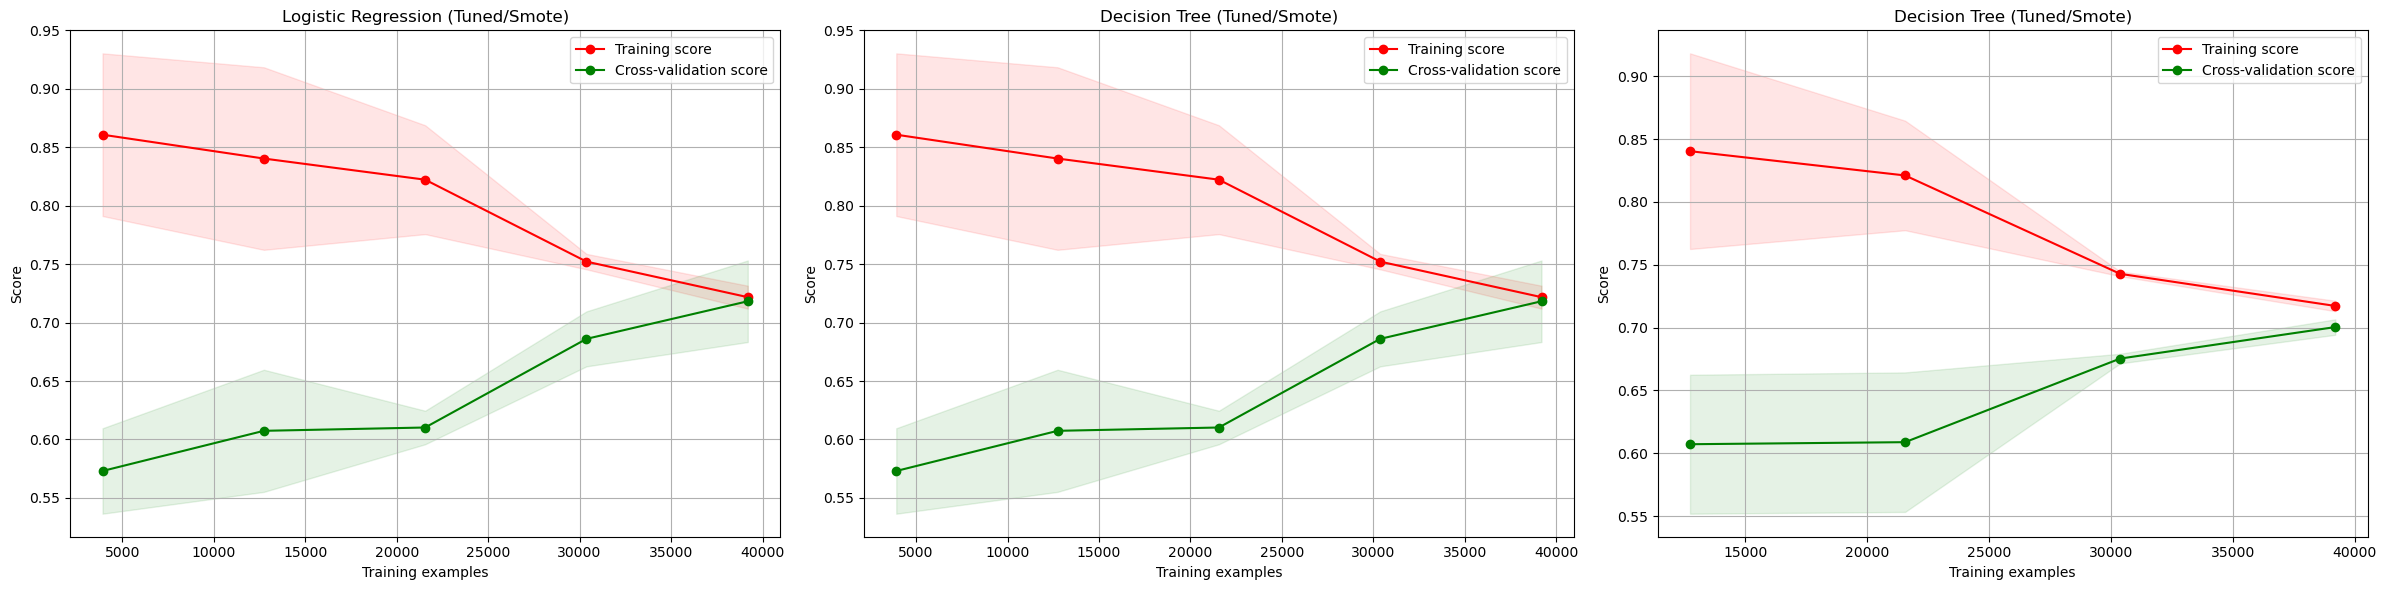

In [80]:
# --- Learning Curve ---
print("\n--- Learning Curve ---")
# Plot learning curves for different models
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
# Logistic Regression
plot_learning_curve(dt_best_model_smote,
                    "Logistic Regression (Tuned/Smote)",  
                    X_smote_train, y_smote_train, axes=axes[0], cv=5)

# Decision Tree
plot_learning_curve(dt_best_model_smote,
                    "Decision Tree (Tuned/Smote)", 
                    X_smote_train, y_smote_train, axes=axes[1], cv=5)

# SVM
plot_learning_curve(svm_smote,
                    "Decision Tree (Tuned/Smote)", 
                    X_smote_train, y_smote_train, axes=axes[2], cv=5)
plt.tight_layout()
plt.show()